# <font color='red'>BackPropagation</font>

## <font color='red'>Loading data </font>

In [ ]:
from google.colab import files
files.upload()

In [2]:
import pickle
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

with open('data.pkl', 'rb') as f:
    data = pickle.load(f)
print(data.shape)
X = data[:, :5]
y = data[:, -1]
print(X.shape, y.shape)

(506, 6)
(506, 5) (506,)


# <font color='red'>Computational graph</font>

<img src='https://i.imgur.com/seSGbNS.png'>


*  **If you observe the graph, we are having input features [f1, f2, f3, f4, f5] and 9 weights [w1, w2, w3, w4, w5, w6,    w7, w8, w9]**.<br><br>
*  **The final output of this graph is a value L which is computed as (Y-Y')^2** 

# <font color='red'>Task 1: Implementing backpropagation and Gradient checking </font>

In [0]:
import math 

def forward_propagation(X_, y_, W):

  def exp_(X__,W__):
    star1 = X__[0]*W__[0]
    star2 = X__[1]*W__[1]
    plus = star1+star2
    star3 = plus**2
    another_plus = star3+W__[5]
    expo = np.exp(another_plus)
    return expo

  expA = exp_(X_,W)

  def tanh_(x,W__):
    plus = x+W__[6]
    tan = np.tanh(plus)
    return tan

  tanhA = tanh_(expA,W)

  def sigmoid_(X__,W__):
    star1 = W__[2]*X__[2]
    star2 = W__[3]*X__[3]
    star3 = W__[4]*X__[4]
    sinx = np.sin(star1)
    plus1 = star2+star3
    star4 = sinx*plus1
    plus2 = star4+W__[7]
    #sig_ = []
    try:
      sigg = 1/(1+(math.exp(-plus2)))
      return sigg
    except:
      return 0.5

  sigmoidA = sigmoid_(X_,W)

  def getyhat(sigmoid_,tanh_,W_):
    star1 = sigmoid_*W_[8]
    plus1 = star1+tanh_
    ydash = plus1
    return ydash

  y_hat = getyhat(sigmoidA,tanhA,W)

  LA = (y_-y_hat)**2

  dLA = -2*(y_-y_hat)

  d = {}

  d['exp'] = expA
  d['sigmoid'] = sigmoidA
  d['tanh'] = tanhA
  d['loss'] = LA
  d['dl'] = dLA
  d['yhat'] = y_hat

  
  return (d)

In [0]:
def backward_propagation(X_, W_, dict_FP):

  W_dict = dict()

  dyhat = np.asarray(dict_FP['dl'])
  dtanh = np.asarray(dict_FP['tanh'])
  dtanhsq = dtanh**2
  dexp = np.asarray(dict_FP['exp'])
  dsigmoid = np.asarray(dict_FP['sigmoid'])

  dw1 = dyhat*2*((W_[0]*X_[0]) + (W_[1]*X_[1])) * (1-dtanhsq) * (dexp) * (X_[0])
  dw2 = dyhat*2*((W_[0]*X_[0]) + (W_[1]*X_[1])) * (1-dtanhsq) * (dexp) * (X_[1])
  dw7 = dyhat*(1 - dtanhsq)
  dw6 = dyhat*(1 - dtanhsq)*dexp

  dw3 = dyhat*W_[8]*dsigmoid*(1-dsigmoid)*((W_[3]*X_[3])+(W_[4]*X_[4]))*(np.cos(W_[2]*X_[2]))*X_[2]
  dw4 = dyhat*W_[8]*dsigmoid*(1-dsigmoid)*np.sin(W_[2]*X_[2])*X_[3]
  dw5 = dyhat*W_[8]*dsigmoid*(1-dsigmoid)*np.sin(W_[2]*X_[2])*X_[4]
  dw8 = dyhat*W_[8]*dsigmoid*(1-dsigmoid)
  dw9 = dyhat*dsigmoid

  W_dict['dw1'] = dw1
  W_dict['dw2'] = dw2
  W_dict['dw3'] = dw3
  W_dict['dw4'] = dw4
  W_dict['dw5'] = dw5
  W_dict['dw6'] = dw6
  W_dict['dw7'] = dw7
  W_dict['dw8'] = dw8
  W_dict['dw9'] = dw9

  return W_dict

 ## <font color='red'>Gradient clipping</font>

<b> Check this  <a href='https://towardsdatascience.com/how-to-debug-a-neural-network-with-gradient-checking-41deec0357a9'>blog link</a> for more details on Gradient clipping

 we know that the derivative of any function is
 
 $$\lim_{\epsilon\to0}\frac{f(x+\epsilon)-f(x-\epsilon)}{2\epsilon}$$


*  The definition above can be used as a numerical approximation of the derivative. Taking an epsilon small enough, the calculated approximation will have an error in the range of epsilon squared. 

*  In other words, if epsilon is 0.001, the approximation will be off by 0.00001.

Therefore, we can use this to approximate the gradient, and in turn make sure that backpropagation is implemented properly. This forms the basis of <b>gradient checking!</b>

## <font color='red'> Implement Gradient checking </font> <br>


In [0]:
def gradient_checking(Xx_, yx_, Wx_):

  dict_FPx = forward_propagation(Xx_, yx_, Wx_)
  L = dict_FPx['loss']

  W_dict =  backward_propagation(Xx_, Wx_, dict_FPx)
  W_grad = []
  for key in W_dict:
    W_grad.append(W_dict[key])
    
  approx_gradients = []

  WFake = Wx_

  for i in range(len(Wx_)):

    WFake[i] = Wx_[i] + 0.0001
    FP=forward_propagation(Xx_,yx_,WFake)
    L_WplusE = FP['loss']

    WFake[i] = Wx_[i] - 0.0002
    FP=forward_propagation(Xx_,yx_,WFake)
    L_WminusE = FP['loss']

    WFake[i] = Wx_[i] + 0.0001

    num = L_WplusE - L_WminusE
    den = 0.0002
    grad_val = num/den

    approx_gradients.append(grad_val)

  comp = []

  for i in range(len(W_grad)):
    compare = (W_grad[i]-approx_gradients[i])/(W_grad[i]+approx_gradients[i])
    comp.append(compare)

  return comp

In [8]:
w=np.ones(9)*0.1
com = gradient_checking(X[0],y[0],w)
com

[1.0370728885929153e-08,
 5.581934643713204e-11,
 1.7287700041112022e-09,
 -1.87486944153289e-12,
 -4.2849738752544037e-10,
 7.610196933782967e-10,
 -3.1480030084674753e-09,
 4.0368014625577295e-10,
 3.361951351774315e-13]

In [0]:
#all the values are very close to zero

# <font color='red'> Task 2 : Optimizers </font>

* As a part of this task, you will be implementing 3 type of optimizers(methods to update weight)
* Use the same computational graph that was mentioned above to do this task
* Initilze the 9 weights from normal distribution with mean=0 and std=0.01

<font color='blue'><b>Algorithm</b>

<pre>
    for each epoch(1-100):
        for each data point in your data:
            using the functions forward_propagation() and backword_propagation() compute the gradients of weights
            update the weigts with help of gradients  ex: w1 = w1-learning_rate*dw1
</pre>

## <font color='red'> Tasks</b>


*  <b>Task 2.1</b>: <b>Vanilla update</b> of weights<br><br>
*  <b>Task 2.2</b>: <b>Momentum update</b> of weights<br><br>
*  <b>Task 2.3</b>:  <b>Adam update</b> of weights


**Note : If you get any assertion error while running grader functions, please print the variables in grader functions and check which variable is returning False .Recheck your logic for that variable .**

<br>
<br>
<br>

# <font color='red'>Task 2: Optimizers

### <font color='blue'>Algorithm with Vanilla update of weights</font>

In [0]:
from tqdm import tqdm

In [13]:
loss_final = []
learning_rate = [0.0001,0.001,0.01,0.1,1,10]
Weights_final = []

for rate in learning_rate:
  Weights = np.random.normal(0,0.01,9)
  Weights_list = []
  loss = []
  for _ in tqdm(range(100)):
    loss_=0 
    for ii in range(len(X)):
      W_gradients = []
      FP_dict = forward_propagation(X[ii], y[ii], Weights)
      W_gradients_dict = backward_propagation(X[ii], Weights, FP_dict)
      loss_ += FP_dict['loss']
      for key in W_gradients_dict:
        W_gradients.append(W_gradients_dict[key])
      for i in range(len(Weights)):
        Weights[i] = Weights[i] - (rate*W_gradients[i])
    
    Weights_list.append(Weights)
    loss.append(loss_/len(X))
  loss_np = np.asarray(loss)
  min_pos = np.argmin(loss_np)
  loss_final.append(loss[min_pos])
  Weights_final.append(Weights_list[min_pos])

print('\nFor Vanilla Update')
lossf_np = np.asarray(loss_final)
min_pos = np.argmin(lossf_np)
print('The minimum loss occurs at learning rate:', learning_rate[min_pos])
print('The minimum loss is:', loss_final[min_pos])
print('The optimum weights are:', Weights_final[min_pos])

100%|██████████| 100/100 [00:03<00:00, 26.88it/s]


For Vanilla Update
The minimum loss occurs at learning rate: 1
The minimum loss is: 1.5296046505401837e-07
The optimum weights are: [-0.02329032  0.01206154 -0.99947182 -0.99736016 -0.99587938  0.92122951
  0.90342098  0.99990797  1.00276283]


In [14]:
loss_final

[0.03128405949215831,
 0.025981444766006712,
 0.0002352382884876722,
 1.8476094577989234e-06,
 1.5296046505401837e-07,
 0.6393551474445257]

<font color='blue'>Plot between epochs and loss</font>

100%|██████████| 100/100 [00:03<00:00, 25.41it/s]


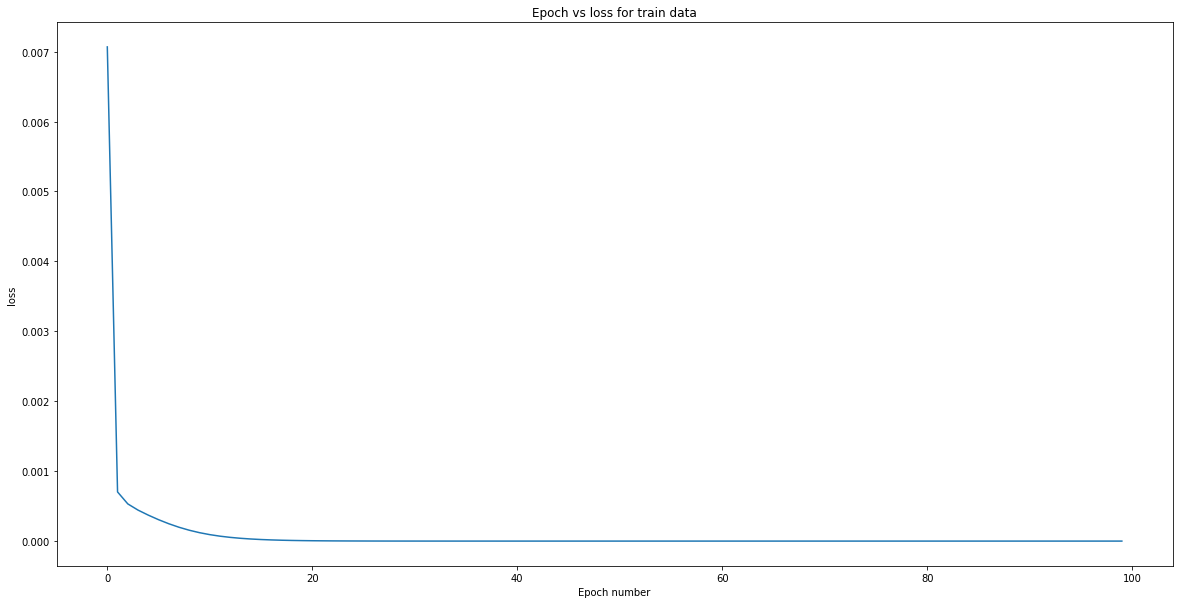

In [26]:
import warnings
warnings.filterwarnings("ignore")

loss_final = []
learning_rate = [1]
Weights_final = []

for rate in learning_rate:
  Weights = np.random.normal(0,0.01,9)
  Weights_list = []
  loss = []
  for _ in tqdm(range(100)):
    loss_=0 
    for ii in range(len(X)):
      W_gradients = []
      FP_dict = forward_propagation(X[ii], y[ii], Weights)
      W_gradients_dict = backward_propagation(X[ii], Weights, FP_dict)
      loss_ += FP_dict['loss']
      for key in W_gradients_dict:
        W_gradients.append(W_gradients_dict[key])
      Weights_list.append(Weights)
      for i in range(len(Weights)):
        Weights[i] = Weights[i] - (rate*W_gradients[i])
    
    loss.append(loss_/len(X))
  loss_np = np.asarray(loss)
  min_pos = np.argmin(loss_np)
  loss_final.append(loss[min_pos])
  Weights_final.append(Weights_list[min_pos])

import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(20,10))
plt.plot(range(100),loss)
plt.xlabel('Epoch number')
plt.ylabel('loss')
plt.title('Epoch vs loss for train data')
plt.show()


### <font color='blue'>Algorithm with momentum update of weights</font>



In [23]:
loss_final = []
learning_rate = [0.0001,0.001,0.01,0.1,1]
Weights_final = []

for rate in learning_rate:
  Weights = np.random.normal(0,0.01,9)
  Weights_list = []
  loss = []
  v=np.zeros(9)
  for _ in tqdm(range(100)):
    loss_=0 
    for ii in range(len(X)):
      W_gradients = []
      FP_dict = forward_propagation(X[ii], y[ii], Weights)
      W_gradients_dict = backward_propagation(X[ii], Weights, FP_dict)
      loss_ += FP_dict['loss']
      for key in W_gradients_dict:
        W_gradients.append(W_gradients_dict[key])
      for i in range(len(Weights)):
        v[i] = (0.9*v[i]) - (rate*W_gradients[i])
        Weights[i] += v[i]

    Weights_list.append(Weights)
    loss.append(loss_/len(X))
  loss_np = np.asarray(loss)
  min_pos = np.argmin(loss_np)
  loss_final.append(loss[min_pos])
  Weights_final.append(Weights_list[min_pos])


print('\nFor Momentum Update')
lossf_np = np.asarray(loss_final)
min_pos = np.argmin(lossf_np)
print('The minimum loss occurs at learning rate:', learning_rate[min_pos])
print('The minimum loss is:', loss_final[min_pos])
print('The optimum weights are:', Weights_final[min_pos])

100%|██████████| 100/100 [00:04<00:00, 23.53it/s]


For Momentum Update
The minimum loss occurs at learning rate: 0.01
The minimum loss is: 2.3972670678697625e-07
The optimum weights are: [ 0.00473384 -0.00559503 -1.00142045 -0.99041021 -0.98569042  0.74254979
  0.63979092  1.00252298  1.00980661]


<font color='blue'>Plot between epochs and loss</font>

100%|██████████| 100/100 [00:04<00:00, 23.12it/s]


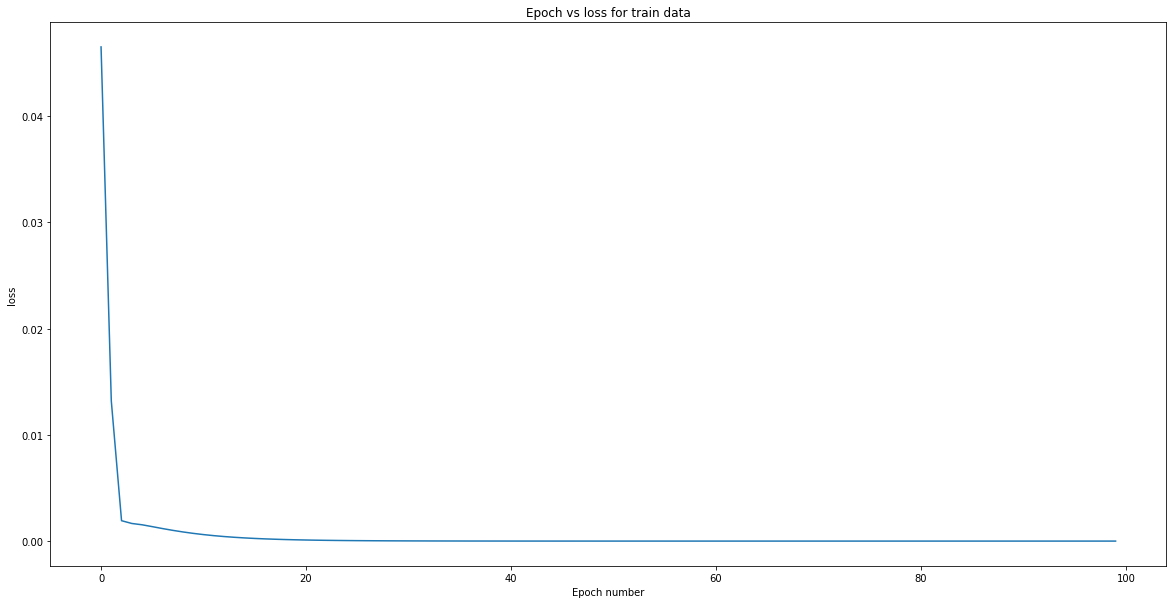

In [27]:
import warnings
warnings.filterwarnings("ignore")

loss_final = []
learning_rate = [0.01]
Weights_final = []

for rate in learning_rate:
  Weights = np.random.normal(0,0.01,9)
  Weights_list = []
  loss = []
  v=np.zeros(9)
  for _ in tqdm(range(100)):
    loss_=0 
    for ii in range(len(X)):
      W_gradients = []
      FP_dict = forward_propagation(X[ii], y[ii], Weights)
      W_gradients_dict = backward_propagation(X[ii], Weights, FP_dict)
      loss_ += FP_dict['loss']
      for key in W_gradients_dict:
        W_gradients.append(W_gradients_dict[key])
      for i in range(len(Weights)):
        v[i] = (0.9*v[i]) - (rate*W_gradients[i])
        Weights[i] += v[i]

    Weights_list.append(Weights)
    loss.append(loss_/len(X))
  loss_np = np.asarray(loss)
  min_pos = np.argmin(loss_np)
  loss_final.append(loss[min_pos])
  Weights_final.append(Weights_list[min_pos])

import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(20,10))
plt.plot(range(100),loss)
plt.xlabel('Epoch number')
plt.ylabel('loss')
plt.title('Epoch vs loss for train data')
plt.show();


### <font color='blue'>Algorithm with Adam update of weights</font>

In [28]:
import math

loss_final = []
learning_rate = [0.0001,0.001,0.01,0.1]
Weights_final = []

for rate in learning_rate:
  Weights = np.random.normal(0,0.01,9)
  Weights_list = []
  loss = []
  v=np.zeros(9)
  m = np.zeros(9)
  for _ in tqdm(range(100)):
    loss_=0 
    for ii in range(len(X)):
      W_gradients = []
      FP_dict = forward_propagation(X[ii], y[ii], Weights)
      W_gradients_dict = backward_propagation(X[ii], Weights, FP_dict)
      loss_ += FP_dict['loss']
      for key in W_gradients_dict:
        W_gradients.append(W_gradients_dict[key])
      for i in range(len(Weights)):
        m[i] = (0.9*m[i]) + (0.1*W_gradients[i])
        v[i] = (0.999*v[i]) + (0.001*(W_gradients[i]**2))
        Weights[i] = Weights[i] - ((rate*m[i])/(math.sqrt(v[i])+0.00000001))

    Weights_list.append(Weights)
    loss.append(loss_/len(X))
  loss_np = np.asarray(loss)
  min_pos = np.argmin(loss_np)
  loss_final.append(loss[min_pos])
  Weights_final.append(Weights_list[min_pos])


print('\nFor Adam update')
lossf_np = np.asarray(loss_final)
min_pos = np.argmin(lossf_np)
print('The minimum loss occurs at learning rate:', learning_rate[min_pos])
print('The minimum loss is:', loss_final[min_pos])
print('The optimum weights are:', Weights_final[min_pos])

100%|██████████| 100/100 [00:05<00:00, 18.46it/s]


For Adam update
The minimum loss occurs at learning rate: 0.0001
The minimum loss is: 1.6481845339961082e-08
The optimum weights are: [-0.74829967 -0.74946971  0.99999896  0.9988696   0.99956451  1.03731408
  0.92782512  1.00005467  0.99971796]


<font color='blue'>Plot between epochs and loss</font>

100%|██████████| 100/100 [00:05<00:00, 19.49it/s]


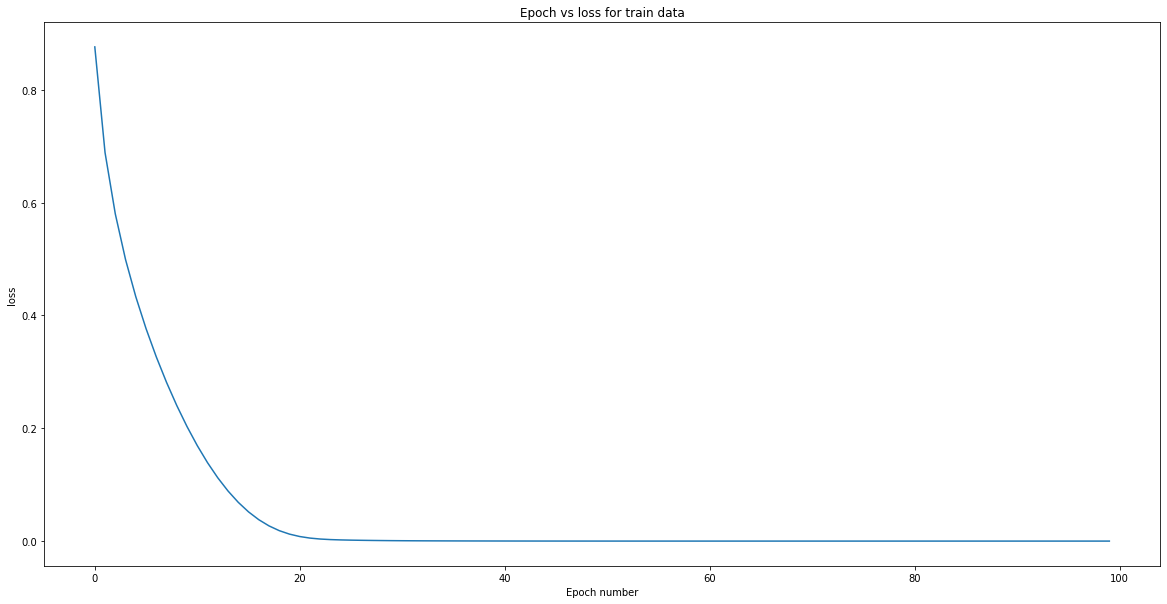

In [30]:
import math

loss_final = []
learning_rate = [0.0001]
Weights_final = []

for rate in learning_rate:
  Weights = np.random.normal(0,0.01,9)
  Weights_list = []
  loss = []
  v=np.zeros(9)
  m = np.zeros(9)
  for _ in tqdm(range(100)):
    loss_=0 
    for ii in range(len(X)):
      W_gradients = []
      FP_dict = forward_propagation(X[ii], y[ii], Weights)
      W_gradients_dict = backward_propagation(X[ii], Weights, FP_dict)
      loss_ += FP_dict['loss']
      for key in W_gradients_dict:
        W_gradients.append(W_gradients_dict[key])
      for i in range(len(Weights)):
        m[i] = (0.9*m[i]) + (0.1*W_gradients[i])
        v[i] = (0.999*v[i]) + (0.001*(W_gradients[i]**2))
        Weights[i] = Weights[i] - ((rate*m[i])/(math.sqrt(v[i])+0.00000001))

    Weights_list.append(Weights)
    loss.append(loss_/len(X))
  loss_np = np.asarray(loss)
  min_pos = np.argmin(loss_np)
  loss_final.append(loss[min_pos])
  Weights_final.append(Weights_list[min_pos])

import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(20,10))
plt.plot(range(100),loss)
plt.xlabel('Epoch number')
plt.ylabel('loss')
plt.title('Epoch vs loss for train data')
plt.show();


<font color='blue'>Comparision plot between epochs and loss with different optimizers</font>

In [31]:
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

learning_rate = [0.0001,0.01,1]
y1=[]
y2=[]
y3=[]

for rate in range(len(learning_rate)):
  list_of_losses=[]
  Weights_vanilla = np.random.normal(0,0.01,9)
  Weights_momentum = np.random.normal(0,0.01,9)
  Weights_adam = np.random.normal(0,0.01,9)
  loss_vanilla = []
  loss_momentum = []
  loss_adam = []
  v_momentum = np.zeros(9)
  v_adam = np.zeros(9)
  m_adam = np.zeros(9)
  for _ in tqdm(range(100)):
    loss_vanilla_=0
    loss_momentum_=0
    loss_adam_=0 
    for ii in range(len(X)):
      #Vanilla
      W_gradients_vanilla = []
      FP_dict_vanilla = forward_propagation(X[ii], y[ii], Weights_vanilla)
      W_gradients_dict_vanilla = backward_propagation(X[ii], Weights_vanilla, FP_dict_vanilla)
      loss_vanilla_ += FP_dict_vanilla['loss']
      for key in W_gradients_dict_vanilla:
        W_gradients_vanilla.append(W_gradients_dict_vanilla[key])
      for i in range(len(Weights_vanilla)):
        Weights_vanilla[i] = Weights_vanilla[i] - (learning_rate[rate]*W_gradients_vanilla[i])
      #Momentum
      W_gradients_momentum = []
      FP_dict_momentum = forward_propagation(X[ii], y[ii], Weights_momentum)
      W_gradients_dict_momentum = backward_propagation(X[ii], Weights_momentum, FP_dict_momentum)
      loss_momentum_ += FP_dict_momentum['loss']
      for key in W_gradients_dict_momentum:
        W_gradients_momentum.append(W_gradients_dict_momentum[key])
      for i in range(len(Weights_momentum)):
        v_momentum[i] = (0.9*v_momentum[i]) - (learning_rate[rate]*W_gradients_momentum[i])
        Weights_momentum[i] += v_momentum[i]
      #Adam
      W_gradients_adam = []
      FP_dict_adam = forward_propagation(X[ii], y[ii], Weights_adam)
      W_gradients_dict_adam = backward_propagation(X[ii], Weights_adam, FP_dict_adam)
      loss_adam_ += FP_dict_adam['loss']
      for key in W_gradients_dict_adam:
        W_gradients_adam.append(W_gradients_dict_adam[key])
      for i in range(len(Weights_adam)):
        m_adam[i] = (0.9*m_adam[i]) + (0.1*W_gradients_adam[i])
        v_adam[i] = (0.999*v_adam[i]) + (0.001*(W_gradients_adam[i]**2))
        Weights_adam[i] = Weights_adam[i] - ((learning_rate[rate]*m_adam[i])/(math.sqrt(v_adam[i])+0.00000001))
    
    loss_vanilla.append(loss_vanilla_/len(X))
    loss_momentum.append(loss_momentum_/len(X))
    loss_adam.append(loss_adam_/len(X))
  
  plt.figure(figsize=(20,10))

  x=range(100)
  y1.append(loss_vanilla)
  y2.append(loss_momentum)
  y3.append(loss_adam)

100%|██████████| 100/100 [00:13<00:00,  7.32it/s]


<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

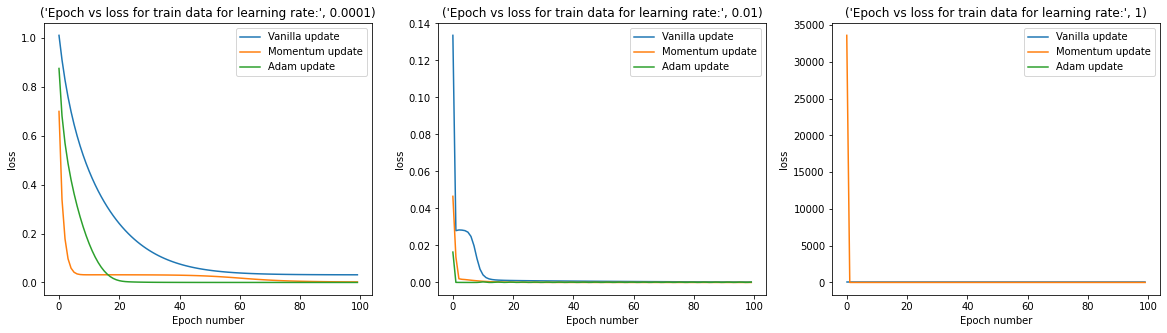

In [33]:
plt.figure(figsize=(20,5))
for i in range(3):
  plt.subplot(1,3,i+1)
  plt.plot(x,y1[i])
  plt.plot(x,y2[i])
  plt.plot(x,y3[i])
  plt.legend(['Vanilla update', 'Momentum update','Adam update'])
  plt.xlabel('Epoch number')
  plt.ylabel('loss')
  plt.title(('Epoch vs loss for train data for learning rate:',learning_rate[i]))

plt.show()

In [0]:
#vanilla update works well with learning rate = 1
#Momentum update works well with learning rate = 0.01
#adam update works well with learning rate = 0.0001